# Mutation-Based Fuzzing

La mayoria de las entradas (inputs) generadas aleatoriamente son invalidad y pueden ser rápidamente rechazadas al momento de ejecutar un programa. Para poder probar una función, por ejemplo, debemos incrementar las chances de crear entradas correctas. Una forma de crear es llamada mutational fuzzing, que basicamente trata de introducir pequeños cambios a entradas que ya sabemos que son validas. Mostraremos como crear mutaciones, y como guiar las mutaciones para tratarde cubrir código que antes no fue probado.

Este capitulo esta 100% basado en el libro de Andreas Zeller, Rahul Gopinath, Marcel Böhme, Gordon Fraser, and Christian Holler, **The Fuzzing Book**, https://www.fuzzingbook.org/html/Fuzzer.html. Retrieved 2024-06-29 17:55:20+02:00.


## Requisitos



In [ ]:
from IPython.display import clear_output
!apt-get update
!apt-get install -y graphviz graphviz-dev
!pip install pygraphviz
!pip install fuzzingbook
from typing import Tuple, List, Callable, Set, Any
from urllib.parse import urlparse
clear_output()


In [ ]:
import fuzzingbook.bookutils.setup




## Ejemplo Rápido
En este capitulo introduciremos la clase MutationFuzzer una clase que toma de entrada una lista de entradas semilla las cuales son mutadas.

In [ ]:
from fuzzingbook.MutationFuzzer import MutationFuzzer
seed_input = "http://www.google.com/search?q=fuzzing"
mutation_fuzzer = MutationFuzzer(seed=[seed_input])
[mutation_fuzzer.fuzz() for i in range(10)]


['http://www.google.com/search?q=fuzzing',
 'htdp:/www(W.wooglecom/search>q=fuzzing',
 'ht|p://www.googulte.com/seUarcj?=uzzing',
 'htp://_ww.google.c\x7fmx/5cearch?q=fuzJzing',
 'http://www.google~.com/searcl?q=fuzzing',
 'http://www.gIoogle.com/sarch>q=fuzzing',
 "http://www.'ogle.com/search?q=fuz{in",
 'i;htp://7ww.google.com/cee8rch?=fuzzqig',
 'http*//www.golVe.com/search?qfuzzing',
 'h4tp:/www.google.com/Asarch?q=fuzzing']

## Motivación: Testing un Parseador de URL

Muchos programas experan que sus entradas vengan en un formato especifico antes de que ellos actualmente puedan procesar la entrada. Por ejemplo, piense en un programa que acepta una URL. La URL tiene que estar en un formato valido, de tal forma que el programa pueda utilizarlo. Cuando hacemos fuzzing de entradas aleatorias, cual es la probabilidad de producir URL validas?

Para ir mas a detalle al problema exploraremos como estan compuestas las URL. Una URL consiste en un numero de elementos

scheme://netloc/path?query#fragment


Donde:
- scheme es un protocolo que se usa, por ejemplo, http, https, ftp, file ...
- netloc es el nombre del host a conectarse, por ejemplo www.google.com
- path es la dirección existente en un host, por ejemplo search
- query es una lista de pares key/value, por ejemplo q=fuzzing
- fragment es un marcador para una localización de un documento extraido, por ejemplo #result

En python, podemos utilizar la función urlparse() para parsear y descomponer una URL en partes.

In [ ]:
urlparse("http://www.google.com/search?q=fuzzing")

ParseResult(scheme='http', netloc='www.google.com', path='/search', params='', query='q=fuzzing', fragment='')

Podemos ver como los resultados muestran cada una de las partes de la URL.

Asumamos que tenemos un programa que toma de entrada una URL. Para simplicar las cosas, haremos que nuestro programa solo verifique la valides de la URL. Si la URL es valida, retorna verdad, caso contrario, lanza una excepción.

In [ ]:
def http_program(url: str) -> bool:
    supported_schemes = ["http", "https"]
    result = urlparse(url)
    if result.scheme not in supported_schemes:
        raise ValueError("Scheme must be one of " +
                         repr(supported_schemes))
    if result.netloc == '':
        raise ValueError("Host must be non-empty")

    # Do something with the URL
    return True

Veamos ahora como hacer fuzzing de http_program(). Para hacer fuzzing, utilizaremos un rango de caracteres ASCII como por ejemplo :,/, y caracteres en minusculas.


In [ ]:
from fuzzingbook.Fuzzer import fuzzer
fuzzer(char_start=32, char_range=96)


'5QZ)~--[})Sdv#m*L0iHh[-MzS.U.X}fG7aA:G<bE\x7fI\'Ofn[",Mx{@jft\x7fo}i3D?7%V7XdtO6BjYEa#'

Ahora intenemos crear 1000 entradas aleatorias y ver si tenemos exito

In [ ]:
for i in range(1000):
    try:
        url = fuzzer()
        result = http_program(url)
        print("Success!")
    except ValueError:
        pass

Cual es la probabilidad de tener una URL valida? Necesitamos un string que empice con http:// o https://. Empezemos por ejemplo con "http://" primero. Estos siete caracters son los que necesitamos empezar. Las chances de producir estos 7 caracteres aletoriamente es 96 a la 7.

In [ ]:
96 ** 7

75144747810816

Cual es la probabilidad de generar "https://"

In [ ]:
96 ** 8

7213895789838336

Lo que nos da una probabilidad de

In [ ]:
likelihood = 1 / (96 ** 7) + 1 / (96 ** 8)
likelihood

1.344627131107667e-14

Si calculamos cuantas iteraciones necesitamos para producir esta entrada seria:

In [ ]:
1/likelihood

74370059689055.02

Veamos cuanto tiempo toma realizar 1000 intentos


In [ ]:
trials = 1000
with Timer() as t:
    for i in range(trials):
        try:
            url = fuzzer()
            result = http_program(url)
            print("Success!")
        except ValueError:
            pass

duration_per_run_in_seconds = t.elapsed_time() / trials
duration_per_run_in_seconds

5.782718099999329e-05

Parece que es rápido, pero desafortunadamente son muchas ejecuciones

In [ ]:
seconds_until_success = duration_per_run_in_seconds * (1 / likelihood)
seconds_until_success

4300610902.619288

En años seria

In [ ]:
hours_until_success = seconds_until_success / 3600
days_until_success = hours_until_success / 24
years_until_success = days_until_success / 365.25
years_until_success

136.27813593617032

Incluso si paralelizamos las cosas, todavia serian meses a años de espera. Por lo que no es una solución viable.



## Mutando Inputs

La alternativa a generar cadenas (string) aleatorias es tomar una entrada valida y realizar mutaciones a la misma. Una mutación en este contexto es una modificación simple a una cadena, por ejemplo, insertando un caracter en algun lugar aletoria o intercambiar caracateres. A esto se le llama mutational fuzzing.

Aqui algunas mutaciones para empezar:

In [ ]:
import random
def delete_random_character(s: str) -> str:
    """Returns s with a random character deleted"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    # print("Deleting", repr(s[pos]), "at", pos)
    return s[:pos] + s[pos + 1:]

In [ ]:
seed_input = "A quick brown fox"
for i in range(10):
    x = delete_random_character(seed_input)
    print(repr(x))

'A quick bown fox'
'A quick brow fox'
'A quick brown fo'
'A quick brwn fox'
'A qick brown fox'
'A quick brwn fox'
'A quic brown fox'
'A quick bron fox'
'A quick bown fox'
'A quickbrown fox'


In [ ]:
def insert_random_character(s: str) -> str:
    """Returns s with a random character inserted"""
    pos = random.randint(0, len(s))
    random_character = chr(random.randrange(32, 127))
    # print("Inserting", repr(random_character), "at", pos)
    return s[:pos] + random_character + s[pos:]

In [ ]:
for i in range(10):
    print(repr(insert_random_character(seed_input)))

'A quick broWwn fox'
'A quick brown foGx'
'A quick brown ?fox'
'A quick brownk fox'
'A quick brownN fox'
'A qu]ick brown fox'
'A quiVck brown fox'
'A quick bro?wn fox'
'A quick brown fWox'
'$A quick brown fox'


In [ ]:
def flip_random_character(s):
    """Returns s with a random bit flipped in a random position"""
    if s == "":
        return s

    pos = random.randint(0, len(s) - 1)
    c = s[pos]
    bit = 1 << random.randint(0, 6)
    new_c = chr(ord(c) ^ bit)
    # print("Flipping", bit, "in", repr(c) + ", giving", repr(new_c))
    return s[:pos] + new_c + s[pos + 1:]

In [ ]:
for i in range(10):
    print(repr(flip_random_character(seed_input)))

'A qUick brown fox'
'A quic{ brown fox'
'A\x00quick brown fox'
'A$quick brown fox'
'A quick\x00brown fox'
'A quick brown foX'
'A quick brown fo8'
'A quick browN fox'
'A quick broWn fox'
'A quick brown &ox'


Ahora definamos un mutador aleatorio que escoge un tipo de mutación de forma aleatoria:

In [ ]:
def mutate(s: str) -> str:
    """Return s with a random mutation applied"""
    mutators = [
        delete_random_character,
        insert_random_character,
        flip_random_character
    ]
    mutator = random.choice(mutators)
    # print(mutator)
    return mutator(s)

In [ ]:
for i in range(10):
    print(repr(mutate("A quick brown fox")))

'A qumck brown fox'
'A quicbk brown fox'
'A quick brow1n fox'
'A quick brown wfox'
'A quick +brown fox'
'A quick brogn fox'
'A quick rown fox'
'A quick `rown fox'
'A qui|ck brown fox'
'A quick brown fo'


## Mutando URLs

Ahora que tenemos un conjunto de mutadores podemos aplicar la tecnica al problema del parseo de URL. Para esto primero creemos una función llamada is_valid_url() que verifica si el http_program() acepta la entrada.

In [ ]:
def is_valid_url(url: str) -> bool:
    try:
        result = http_program(url)
        return True
    except ValueError:
        return False

In [ ]:
assert is_valid_url("http://www.google.com/search?q=fuzzing")
assert not is_valid_url("xyzzy")

NameError: name 'http_program' is not defined

Ahora apliquemos la funcion mutate tomando una URL valida de entrada y veamos que optenemos:

In [ ]:
seed_input = "http://www.google.com/search?q=fuzzing"
valid_inputs = set()
trials = 20

for i in range(trials):
    inp = mutate(seed_input)
    if is_valid_url(inp):
        valid_inputs.add(inp)
valid_inputs

{'http://www.*google.com/search?q=fuzzing',
 'http://www.google,com/search?q=fuzzing',
 'http://www.google.cDom/search?q=fuzzing',
 'http://www.google.co$m/search?q=fuzzing',
 'http://www.google.com/qsearch?q=fuzzing',
 'http://www.google.com/sPearch?q=fuzzing',
 'http://www.google.com/searCh?q=fuzzing',
 'http://www.google.com/search?hq=fuzzing',
 'http://www.google.com/search?q=fuzjing',
 'http://www.google.com/search?q=fuzzig',
 'http://www.google.com/search?q=gfuzzing',
 'http://www.google.com/search?q=uzzing',
 'http://www.google.com/search?q?fuzzing',
 'http://www.google.com/searchq=fuzzing',
 'http://www.googne.com/search?q=fuzzing',
 'http://www.oogle.com/search?q=fuzzing'}

Ahora podemos observar que mutando una URL original podemos prodcuir entradas validas. La probabilidad seria:


In [ ]:
len(valid_inputs) / trials


0.8

## Multiple Mutations

Hasta el momento solo hemos aplicado un mutacion en una cadena. Sin embargo, podemos aplicar multiple mutaciones a la misma cadena para cambiara aun mas. Que sucederia por ejemplo, si aplicamos 20 mutaciones a una cadena?

In [ ]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutations = 50

In [ ]:
inp = seed_input
for i in range(mutations):
    if i % 5 == 0:
        print(i, "mutations:", repr(inp))
    inp = mutate(inp)

0 mutations: 'http://www.google.com/search?q=fuzzing'
5 mutations: 'http://www\x0eooogle.cm/search?=fuzz~ing'
10 mutations: 'PhttpT://$wsw\x0eooogle.cm/suearch?=fuzz~ing'
15 mutations: 'PhttT://wsw\x0eoooge>c|m/suearch?=fuzz~ing'
20 mutations: 'PtT://wsw\x0eooge>c|m/sue"arch?=fuzr~ing'
25 mutations: 'PtT://wsw\x0eooge>c|m/sue"rchs?=f5r~ing*'
30 mutations: 'PtT://wsw\x0eoge>cz|m/sue"rcs?=f5p~iqng*'
35 mutations: 'PtT://wisw\x0eoce>cz|m/su%"rgs=f5p~iqng*'
40 mutations: 'PtT:%//wiIsw/\x0eoce>cz|m/s%"rgs=f5ps~iqng*'
45 mutations: 'PtT:%/\'wiIsw/\x0eoc>cz|m/s%"gs=f5ps~iqng*?S'


Como se puede ver la semilla original de entrada es dificil de reconocer. Si mutamos muchas veces, tenemos una mayor variedad de entradas.

Para implementar este tipo de mutaciones, introduciremos la clase MutationFuzzer. Que toma de entrada una lista de string, un numero minimo y maximo de mutaciones.

In [ ]:
class MutationFuzzer(Fuzzer):
    """Base class for mutational fuzzing"""

    def __init__(self, seed: List[str],
                 min_mutations: int = 2,
                 max_mutations: int = 10) -> None:
        """Constructor.
        `seed` - a list of (input) strings to mutate.
        `min_mutations` - the minimum number of mutations to apply.
        `max_mutations` - the maximum number of mutations to apply.
        """
        self.seed = seed
        self.min_mutations = min_mutations
        self.max_mutations = max_mutations
        self.reset()

    def reset(self) -> None:
        """Set population to initial seed.
        To be overloaded in subclasses."""
        self.population = self.seed
        self.seed_index = 0


A continuación, desarrollaremos MutationFuzzer agregandole mas metodos. Para ir agregando método por método a la clase utilizaremos un hack de python: Donde queramos introducir un nuevo método a una clase C, usaremos el siguiente patron:


In [ ]:
class MutationFuzzer(MutationFuzzer):
    def mutate(self, inp: str) -> str:
        return mutate(inp)

El código anterior agrega el metodo mutate a la clase MutationFuzzer. Ahora volvamos a la estrategia de maximizar la diversidad en nuestra población. Primero, crearemos un método que cree un candidato, el cual eliga aleatoriamente algunas entradas de nuestra poblacion y aplica un numero de mutaciones entre el minimo y maximo definidos.

In [ ]:
class MutationFuzzer(MutationFuzzer):
    def create_candidate(self) -> str:
        """Create a new candidate by mutating a population member"""
        candidate = random.choice(self.population)
        trials = random.randint(self.min_mutations, self.max_mutations)
        for i in range(trials):
            candidate = self.mutate(candidate)
        return candidate

El método fuzz() permitira extraer una por una las semillas y cuando no existan mas semillas empezara a crear mutaciones:

In [ ]:
class MutationFuzzer(MutationFuzzer):
    def fuzz(self) -> str:
        if self.seed_index < len(self.seed):
            # Still seeding
            self.inp = self.seed[self.seed_index]
            self.seed_index += 1
        else:
            # Mutating
            self.inp = self.create_candidate()
        return self.inp

Aqui es donde utilizamos el método fuzz(). Para cada invocacion al método fuzz(), tenemos otra variate con multiple mutaciones aplicadas.



In [ ]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutation_fuzzer = MutationFuzzer(seed=[seed_input])
mutation_fuzzer.fuzz()

'http://www.google.com/search?q=fuzzing'

In [ ]:
mutation_fuzzer.fuzz()


'htpp://www.google.col/search?q=fuzzing'

Mientras mas grande sea la variedad de entradas, incrementara el riesgo de tener una entrada valida. La clave del proceso es la idea de guiar las mutaciones, manteniendo aquellas que son especialmente valuables.

## Guiando las mutaciones con el coverage



In [ ]:
class FunctionRunner(Runner):
    def __init__(self, function: Callable) -> None:
        """Initialize.  `function` is a function to be executed"""
        self.function = function

    def run_function(self, inp: str) -> Any:
        return self.function(inp)

    def run(self, inp: str) -> Tuple[Any, str]:
        try:
            result = self.run_function(inp)
            outcome = self.PASS
        except Exception:
            result = None
            outcome = self.FAIL

        return result, outcome

In [ ]:
http_runner = FunctionRunner(http_program)
http_runner.run("https://foo.bar/")

(True, 'PASS')

Ahora podemos extender la funcionalidad de FunctionRunner que tambien mide el coverage. Despues de invokar run(), el método coverage retorna el coverage obtenido en la ultima corrida.

In [ ]:
from typing import Any, Optional, Callable, List, Type, Set, Tuple
from types import FrameType, TracebackType
import sys
Location = Tuple[str, int]

class CoverageM:
    """Track coverage within a `with` block. Use as
    ```
    with Coverage() as cov:
        function_to_be_traced()
    c = cov.coverage()
    ```
    """

    def __init__(self) -> None:
        """Constructor"""
        self._trace: List[Location] = []

    # Trace function
    def traceit(self, frame: FrameType, event: str, arg: Any) -> Optional[Callable]:
        """Tracing function. To be overloaded in subclasses."""
        if self.original_trace_function is not None:
            self.original_trace_function(frame, event, arg)

        if event == "line":
            function_name = frame.f_code.co_name
            lineno = frame.f_lineno
            if function_name != '__exit__':  # avoid tracing ourselves:
                self._trace.append((function_name, lineno))

        return self.traceit

    def __enter__(self) -> Any:
        """Start of `with` block. Turn on tracing."""
        self.original_trace_function = sys.gettrace()
        sys.settrace(self.traceit)
        return self

    def __exit__(self, exc_type: Type, exc_value: BaseException,
                 tb: TracebackType) -> Optional[bool]:
        """End of `with` block. Turn off tracing."""
        sys.settrace(self.original_trace_function)
        return None  # default: pass all exceptions

    def trace(self) -> List[Location]:
        """The list of executed lines, as (function_name, line_number) pairs"""
        return self._trace

    def coverage(self) -> Set[Location]:
        """The set of executed lines, as (function_name, line_number) pairs"""
        return set(self.trace())

    def function_names(self) -> Set[str]:
        """The set of function names seen"""
        return set(function_name for (function_name, line_number) in self.coverage())

    def __repr__(self) -> str:
        """Return a string representation of this object.
           Show covered (and uncovered) program code"""
        t = ""
        for function_name in self.function_names():
            # Similar code as in the example above
            try:
                fun = eval(function_name)
            except Exception as exc:
                t += f"Skipping {function_name}: {exc}"
                continue

            source_lines, start_line_number = inspect.getsourcelines(fun)
            for lineno in range(start_line_number, start_line_number + len(source_lines)):
                if (function_name, lineno) not in self.trace():
                    t += "# "
                else:
                    t += "  "
                t += "%2d  " % lineno
                t += source_lines[lineno - start_line_number]

        return t

In [ ]:
class FunctionCoverageRunner(FunctionRunner):
    def run_function(self, inp: str) -> Any:
        with CoverageM() as cov:
            try:
                result = super().run_function(inp)
            except Exception as exc:
                self._coverage = cov.coverage()
                raise exc
        self._coverage = cov.coverage()
        return result

    def coverage(self) -> Set[Location]:
        return self._coverage

In [ ]:
http_runner = FunctionCoverageRunner(http_program)
http_runner.run("https://foo.bar/")

(True, 'PASS')

Los cinco statements cubiertos son:


In [ ]:
print(list(http_runner.coverage())[:5])

[('urlsplit', 475), ('extract_stack', 225), ('extract', 358), ('_get_stack_str', 42), ('splitext', 124)]


Mantenemos la poblacion y un conjunto de coverage guardados en coverages_seen. La función fuzz toma la entrada y corre la función con ella. Si el coverage es nuevo, es decir no esta en los coverages vistos (coverages_seen), la entrada es agregada a la poblacion y a la lista de coverages vistos.

In [ ]:
class MutationCoverageFuzzer(MutationFuzzer):
    """Fuzz with mutated inputs based on coverage"""

    def reset(self) -> None:
        super().reset()
        self.coverages_seen: Set[frozenset] = set()
        # Now empty; we fill this with seed in the first fuzz runs
        self.population = []

    def run(self, runner: FunctionCoverageRunner) -> Any:
        """Run function(inp) while tracking coverage.
           If we reach new coverage,
           add inp to population and its coverage to population_coverage
        """
        result, outcome = super().run(runner)
        new_coverage = frozenset(runner.coverage())
        if outcome == Runner.PASS and new_coverage not in self.coverages_seen:
            # We have new coverage
            self.population.append(self.inp)
            self.coverages_seen.add(new_coverage)

        return result

Ahora utilizamos la clase con nuestras mejoras.

In [ ]:
seed_input = "http://www.google.com/search?q=fuzzing"
mutation_fuzzer = MutationCoverageFuzzer(seed=[seed_input])
mutation_fuzzer.runs(http_runner, trials=10000)
mutation_fuzzer.population

['http://www.google.com/search?q=fuzzing',
 'http://www.Ngoogle.com/searCh>q=fuzi=ng',
 'http://www.Ngoogle.co|meaVCh>q=fuzi=ng',
 'http://www.sN@NKgoogle.com/searC>q=fuzi=',
 'http://www.rN@fKgooglencom/sarC?q=0fuFzi[=',
 'httP://wvw.google.com/se<arch?qh=fuzzing#',
 'http://ww.sN@FKgoogle.#om/{earC>q=gu&i9',
 'http://w.sN@FKgnogle/#om/{earC?q=gu&i9',
 'httP://wvw.google.bom/se<arch?qh=?f%uxjinG#',
 'http://www.r@KgooDghensom/sarC;q=0f>uFi[/=',
 'http://www.r@KgooDhensom/sar\x03;q=0f>uFi[o=',
 'http://wwwr@KgooDhensom/sar\x03;q?0fuFi[o=',
 'http://www>rHggoghenom/sarC;=n0f>uFi[/',
 'http://wvwr@GmooDhenom/jsar\x03;q?0fui[o=',
 'http://www.Ngoogle.co\\|meaCh>1=fuJzi=ng',
 'http://\x7fww.r@KgooDhensom/3ar\x03;q=0f>uF[o=',
 "http://wwwr@KgooDhensom/saLr\x03;q?#0fuVi['o=",
 "http://wwwr@KgooDhe.som/saLr\x03;q?#0fuVi['o=c",
 "http://wwr@KgooDlensom/saLr\x03;q#0fui['o=",
 "http://wwwr@KgooDhe.om/saLr\x03h;q/#0fuVi['o=c",
 "http://wwwr@Kgo*Dhe8.Om/saLr\x03h;qY/#0fuVI['o=co",
 "http://6wwr@Kg

Lo logramos, nuestra poblacion, cada entrada ahora es valida y tiene diferente coverage.

In [ ]:
all_coverage, cumulative_coverage = population_coverage(
    mutation_fuzzer.population, http_program)


In [ ]:
import matplotlib.pyplot as plt

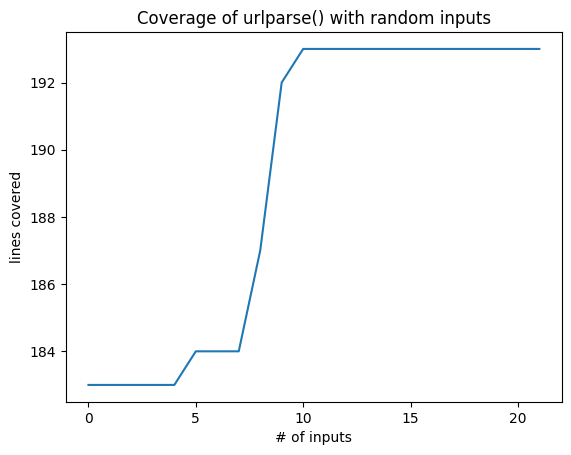

In [ ]:
plt.plot(cumulative_coverage)
plt.title('Coverage of urlparse() with random inputs')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');

Lo bueno de esta estrategia es que se puede aplicar en programas muy largos, y explorar un path tras otro cubriendo diferentes funcionalidades.

## Lecciones Aprendidas

- Las entradas generadas aletoriamente son generalmente invalidads.
- Mutaciones de entradas validas tiene mas chances de ser validas.